In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_atmos
from funzioni import plot_bias_tos
from funzioni import plot_mean_cluster_atmos
from funzioni import plot_5_mean_cluster_atmos
from funzioni import plot_mean_cluster_tos
from funzioni import plot_bias_2_models_atmos
from funzioni import plot_bias_2_models_tos
from funzioni import plot_std_cluster_atmos
from funzioni import plot_zonmean
from funzioni import plot_zonmean_2_cluster
from funzioni import plot_mean_cluster_zonmean
from funzioni import plot_std_cluster_tos
from funzioni import plot_std_cluster_zonmean
from funzioni import bs_sample_mean
from funzioni import bs_compute_array_mean_std_95cl
from funzioni import plot_bs_95cl_mean_std
from funzioni import bs_compute_matrix10
from funzioni import plot_bs_mean_cluster_matrix10
from funzioni import plot_bs_diff_cluster
from funzioni import compute_mean
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import plotly.express as px
import dill
import pickle
import cartopy.crs as ccrs
import random
from matplotlib.lines import Line2D

Caricamento file pickle

In [2]:
# Caricamento di models e models_atmos
with open('models_atmos_new.pkl','rb') as file:
    models_atmos = dill.load(file)
    era_na_seas_mean = dill.load(file)
    list_4_clusters_new = dill.load(file)
with open('models.pkl', 'rb') as file:
    models = dill.load(file)
    esa_na_seas_mean_tos = dill.load(file)
    dataset_ESA_na_celsius = dill.load(file)

Inizio con linear regression tra bias di vento zonale e risoluzione atmosferica: ricerco mappa di coefficienti angolari m per ogni punto griglia

Creo la matrice Y con dimensioni = (35,30x78)
- Creo la matrice Y di numero di righe = # modelli e numero di colonne pari al numero di punti griglia.
- Se l'elemento ij-esimo è nan elimino tutta la colonna 
- All'interno della matrice ci sono i valori di bias di vento zonale a 850hPa

In [3]:
n_rows = len(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'].lat.values) # prendo un modello generico e calcolo il numero di righe, pari al numero di grid cell sulla latitudine
n_cols = len(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'].lon.values) #il numero di colonne è pari al numero di grid cell sulla longitudine
n_elements = n_rows * n_cols
n_models = len(models_atmos) # numero di modelli

In [4]:
np_array_models_2d = np.zeros((n_rows,n_cols)) #inizializzazione array 2-dim, che ha sulle colonne la longitudine e sulle righe la latitudine e andrò a mettere i valori dei bias di temperatura della stagione MAM
np_array_models_1d = np.zeros(n_elements) #inizializzazione array 1-dim, creato con righe di np_array_models_2d messe una accanto all'altra
Y_init = np.zeros((n_models,n_elements)) #inizializzazione matrice con righe pari al numero di modelli e per ogni riga vado a mettere 
i = 0 #inizializzazione indice righe feature_matrix_init
Y_init.shape

(35, 2340)

In [5]:
for name in models_atmos.keys(): #models_list è una lista contenente il nome di tutti i modelli che sto utilizzando. Quindi ciclo sul numero dei modelli
    #Creo array
    np_array_models_2d = models_atmos[name]['atmos North Atlantic bias DJF'].values #estraggo i valori da bias MAM e li metto in un array 2d, dove sulle righe c'è la latitudine e sulle colonne la longitudine
    np_array_models_1d = np_array_models_2d.flatten() #array 1d con numero di elementi pari a lat x lon (messe una accanto all'altra le righe dell'array 2d precedente)
    #Creo feature matrix
    Y_init[i,:] = np_array_models_1d #ogni riga di feature_matrix_init è pari a np_array_models_1d
    i = i + 1 #aggiorno indice i

In [6]:
Y_init.shape

(35, 2340)

Elimino le colonne contenenti 'nan'

In [7]:
#Elimino le colonne che contengono almeno un nan e creo la feature_matrix
Y = np.empty((n_models,0)) #inizializzo la nuova feature matrix, cioè la matrice senza nan
number_nan = 0 #inizializzo il numero dei number nan
arr = np.zeros(n_models) #inizializzo array di dimensione pari al numero di modelli
cell_grid_nan = [] #lista vuota che contiene il numero delle celle della griglia che hanno elementi nan e che quindi vengono eliminate per il calcolo di feature_matrix

for j in range(n_elements): #ciclo sulle colonne di feature_matrix_init   
    if np.isnan(Y_init[:,j]).any(): #se c'è almeno un elemento nan all'interno della colonna
        cell_grid_nan.append(j) #costruisco la cella con il numero delle colonne che contengono elementi nan
        number_nan = number_nan + 1 #aggiorno il numero di colonne che hanno almeno un elemento nan
    else: #se la colonna non contiene nan
        arr = Y_init[:,j]
        Y = np.column_stack((Y,arr)) #aggiungo la colonna di feature_matrix_init senza nan alla matrice feature_matrix
    

In [8]:
print(cell_grid_nan)

[10, 11, 12, 88, 89, 165, 166, 167, 243, 320, 321, 476, 550, 551, 552, 553, 554, 555, 556, 557, 627, 628, 629, 630, 631, 632, 633, 634, 635, 705, 706, 707, 708, 709, 710, 711, 712, 713, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 861, 862, 863, 864, 865, 866, 867, 868, 869, 940, 941, 942, 943, 944, 945, 1174, 1677, 1678, 1754, 1755, 1756, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303,

In [9]:
len(cell_grid_nan)

187

In [10]:
Y.shape

(35, 2153)

Funzione per array X generico

In [11]:
#Creo un vettore x di dimensioni pari al numero dei modelli, in cui vado ad inserire i valori di risoluzione atmosferica(opp. ris. oceanica, o la posizione della gulf stream, o RMSE oceanico) per ogni modello
def compute_array_X(n_models,name_dict): #n_models = models/models_atmos; name_dict = ris. atm/oceanica,... Ad es. è'atmos model resolution' in models_atmos[name]['atmos model resolution']
    X = np.zeros(len(n_models)) # inizializzo l'array X, di dimensioni pari al numero di modelli
    n = 0 #inizializzo indice array X
    for name in n_models.keys():
        X[n] = n_models[name][name_dict]
        n = n + 1
    return X

Funzione per coefficiente angolare m e m_reshape per poterlo plottare

In [12]:
def compute_angular_coefficient(Y,X,n_rows,n_cols,cell_grid_nan):
    #Inizializzo il vettore m = coefficiente angolare di dimensioni pari al numero di punti griglia, cioè pari al numero di colonne della matrice Y
    m = np.zeros((Y.shape[1]))
    #Faccio il fit lineare
    for j in range(Y.shape[1]): #ciclo su tutti i punti griglia, cioè sulle colonne della matrice Y
        coefficients = np.polyfit(X,Y[:,j],1)
        m[j],q = coefficients
    #Faccio il reshape di m in modo tale che abbia dimensioni pari a latxlon, cioè n_rows x n_cols
    #Creo matrice m_reshape
    k = 0 #indice per il vettore cell_grid_nan
    l = 0 #indice per il vettore m
    p = 0
    m_reshape = np.zeros((n_rows,n_cols)) #m_reshape matrice di dimensioni latxlon per poter plottare m, insieme agli elementi nan tolti all'inizio
    for i in range(n_rows): 
        for j in range(n_cols): 
            #print(p,k)     
            if k < len(cell_grid_nan) and p == cell_grid_nan[k]: #elemento p-esimo è nan, metto k-1 perché cell_grid_nan inizia da 0
                m_reshape[i,j] = np.nan 
                k = k + 1
            else:
                m_reshape[i,j] = m[l]
                l = l + 1
            p = p + 1
    return m, m_reshape

Funzione per il plot di m_reshape

In [18]:
#Plot di m_reshape per vedere quandto valgono gli m nel box lonxlat considerato
def plot_m_reshape(box,m_reshape,title_plot): #box = models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF']
    fig,ax = plt.subplots(figsize=(10,5), subplot_kw={"projection": ccrs.PlateCarree()})
    min_lon = box.lon.values.min()
    max_lon = box.lon.values.max()
    min_lat = box.lat.values.min()
    max_lat = box.lat.values.max()
    plot_mod = ax.imshow(m_reshape[::-1], aspect='auto',cmap='seismic',extent=[min_lon, max_lon, min_lat, max_lat], transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_xticks(np.arange(min_lon,max_lon, 20), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(min_lat,max_lat, 10), crs=ccrs.PlateCarree())
    ax.set_xlabel('longitude(deg)')
    ax.set_ylabel('latitude(deg)')
    fig.colorbar(plot_mod, ax=ax).set_label('Angular Coefficient Value')
    fig.suptitle(title_plot)
    fig.show()

Linear regression con x = risoluzione atmosferica

In [13]:
X_atmos_res = compute_array_X(models_atmos,'atmos model resolution')

In [17]:
m_atmos_res, m_reshape_atmos_res = compute_angular_coefficient(Y,X_atmos_res,n_rows,n_cols,cell_grid_nan)

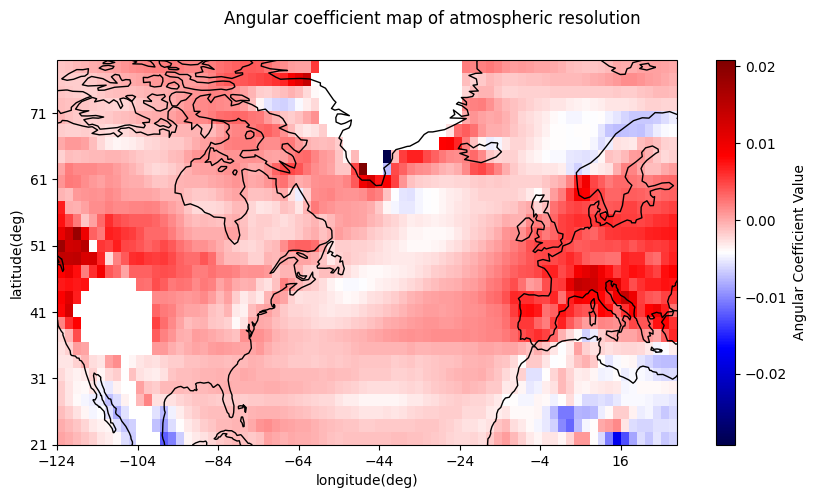

In [19]:
plot_m_reshape(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'],m_reshape_atmos_res,'Angular coefficient map of atmospheric resolution')

Linear regression con x = risoluzione oceanica

In [20]:
X_ocean_res = compute_array_X(models,'model resolution')

In [21]:
m_ocean_res, m_reshape_ocean_res = compute_angular_coefficient(Y,X_ocean_res,n_rows,n_cols,cell_grid_nan)

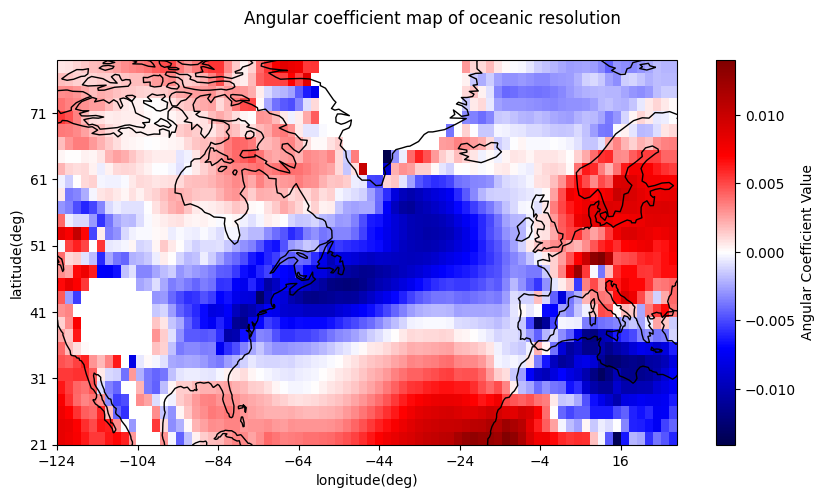

In [23]:
plot_m_reshape(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'],m_reshape_ocean_res,'Angular coefficient map of oceanic resolution')

Linear regression con x = posizione gulf stream, cioè latitudine

In [25]:
X_gs_latitude = compute_array_X(models,'gs latitude')

In [26]:
m_gs_latitude, m_reshape_gs_latitude = compute_angular_coefficient(Y,X_gs_latitude,n_rows,n_cols,cell_grid_nan)

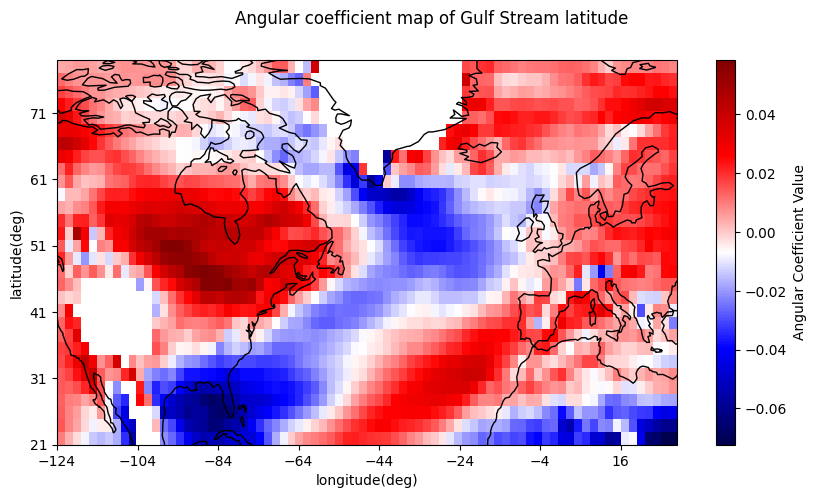

In [27]:
plot_m_reshape(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'],m_reshape_gs_latitude,'Angular coefficient map of Gulf Stream latitude')

Linear regression con x = RMSE oceanico

In [28]:
X_ocean_rmse = compute_array_X(models,'rms error')

In [29]:
m_ocean_rmse, m_reshape_ocean_rmse = compute_angular_coefficient(Y,X_ocean_rmse,n_rows,n_cols,cell_grid_nan)

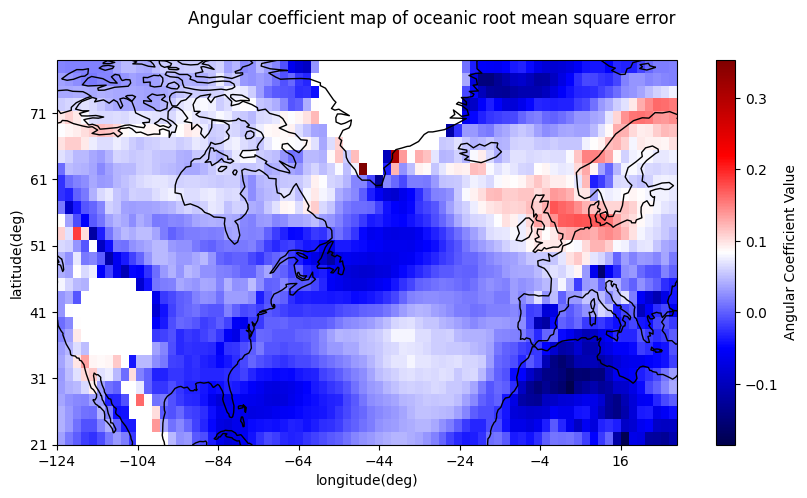

In [30]:
plot_m_reshape(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'],m_reshape_ocean_rmse,'Angular coefficient map of oceanic root mean square error')